# Telecom Churn Prediction

# 1. Loading dependencies & datasets

In [306]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
# pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [307]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [308]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


Let's look at each variable's datatype:

In [309]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

Let's also summarize the features using the df.describe method:

In [310]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


# 2. Create X, y

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [311]:
data['circle_id'].value_counts()

109    69999
Name: circle_id, dtype: int64

In [312]:
X = data.drop(['circle_id'],1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 170), (69999,))

In [313]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [314]:
# X_train.head()

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

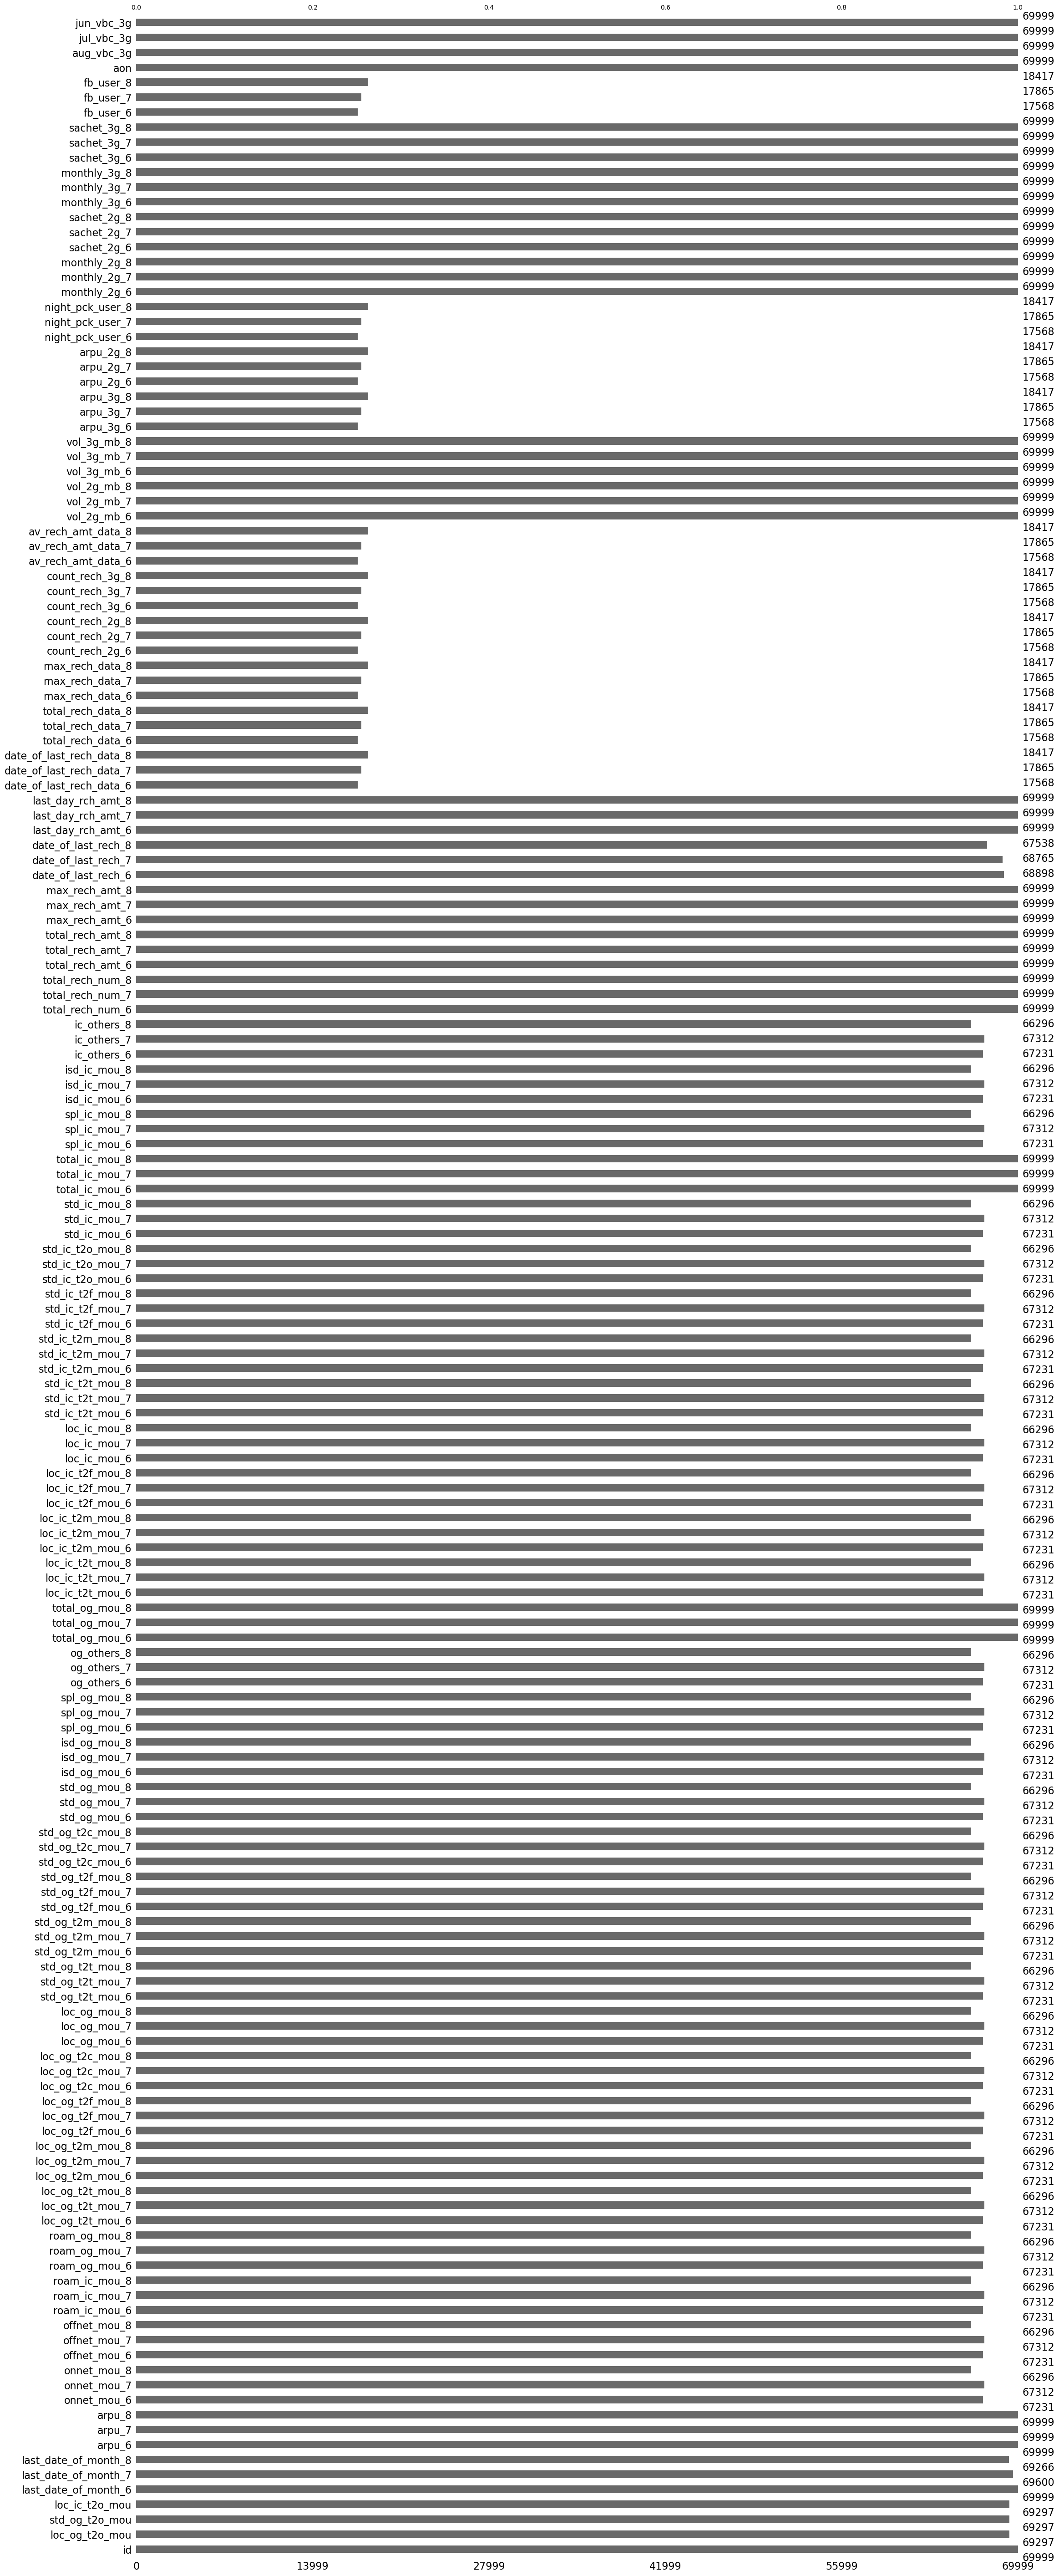

In [315]:
msno.bar(X)

Lets also calculate the % missing data for each column:

In [316]:
missing_data_percent = 100*X.isnull().sum()/len(y)
missing_data_percent

id                       0.000000
loc_og_t2o_mou           1.002871
std_og_t2o_mou           1.002871
loc_ic_t2o_mou           1.002871
last_date_of_month_6     0.000000
                          ...    
fb_user_8               73.689624
aon                      0.000000
aug_vbc_3g               0.000000
jul_vbc_3g               0.000000
jun_vbc_3g               0.000000
Length: 170, dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [317]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=140)

In [318]:
X = X[new_vars]
X.shape

(69999, 140)

In [319]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 140 entries, id to jun_vbc_3g
dtypes: float64(108), int64(26), object(6)
memory usage: 74.8+ MB


In [320]:
object_columns = X.select_dtypes(include=['object']).columns
print(object_columns)

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'],
      dtype='object')


In [321]:
X = X.drop(object_columns, axis=1)

In [322]:
missing_data_percent = X.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_o

In [323]:
len(impute_cols)

90

In [324]:
imp = SimpleImputer(strategy='median')
X[impute_cols] = imp.fit_transform(X[impute_cols])

<Axes: >

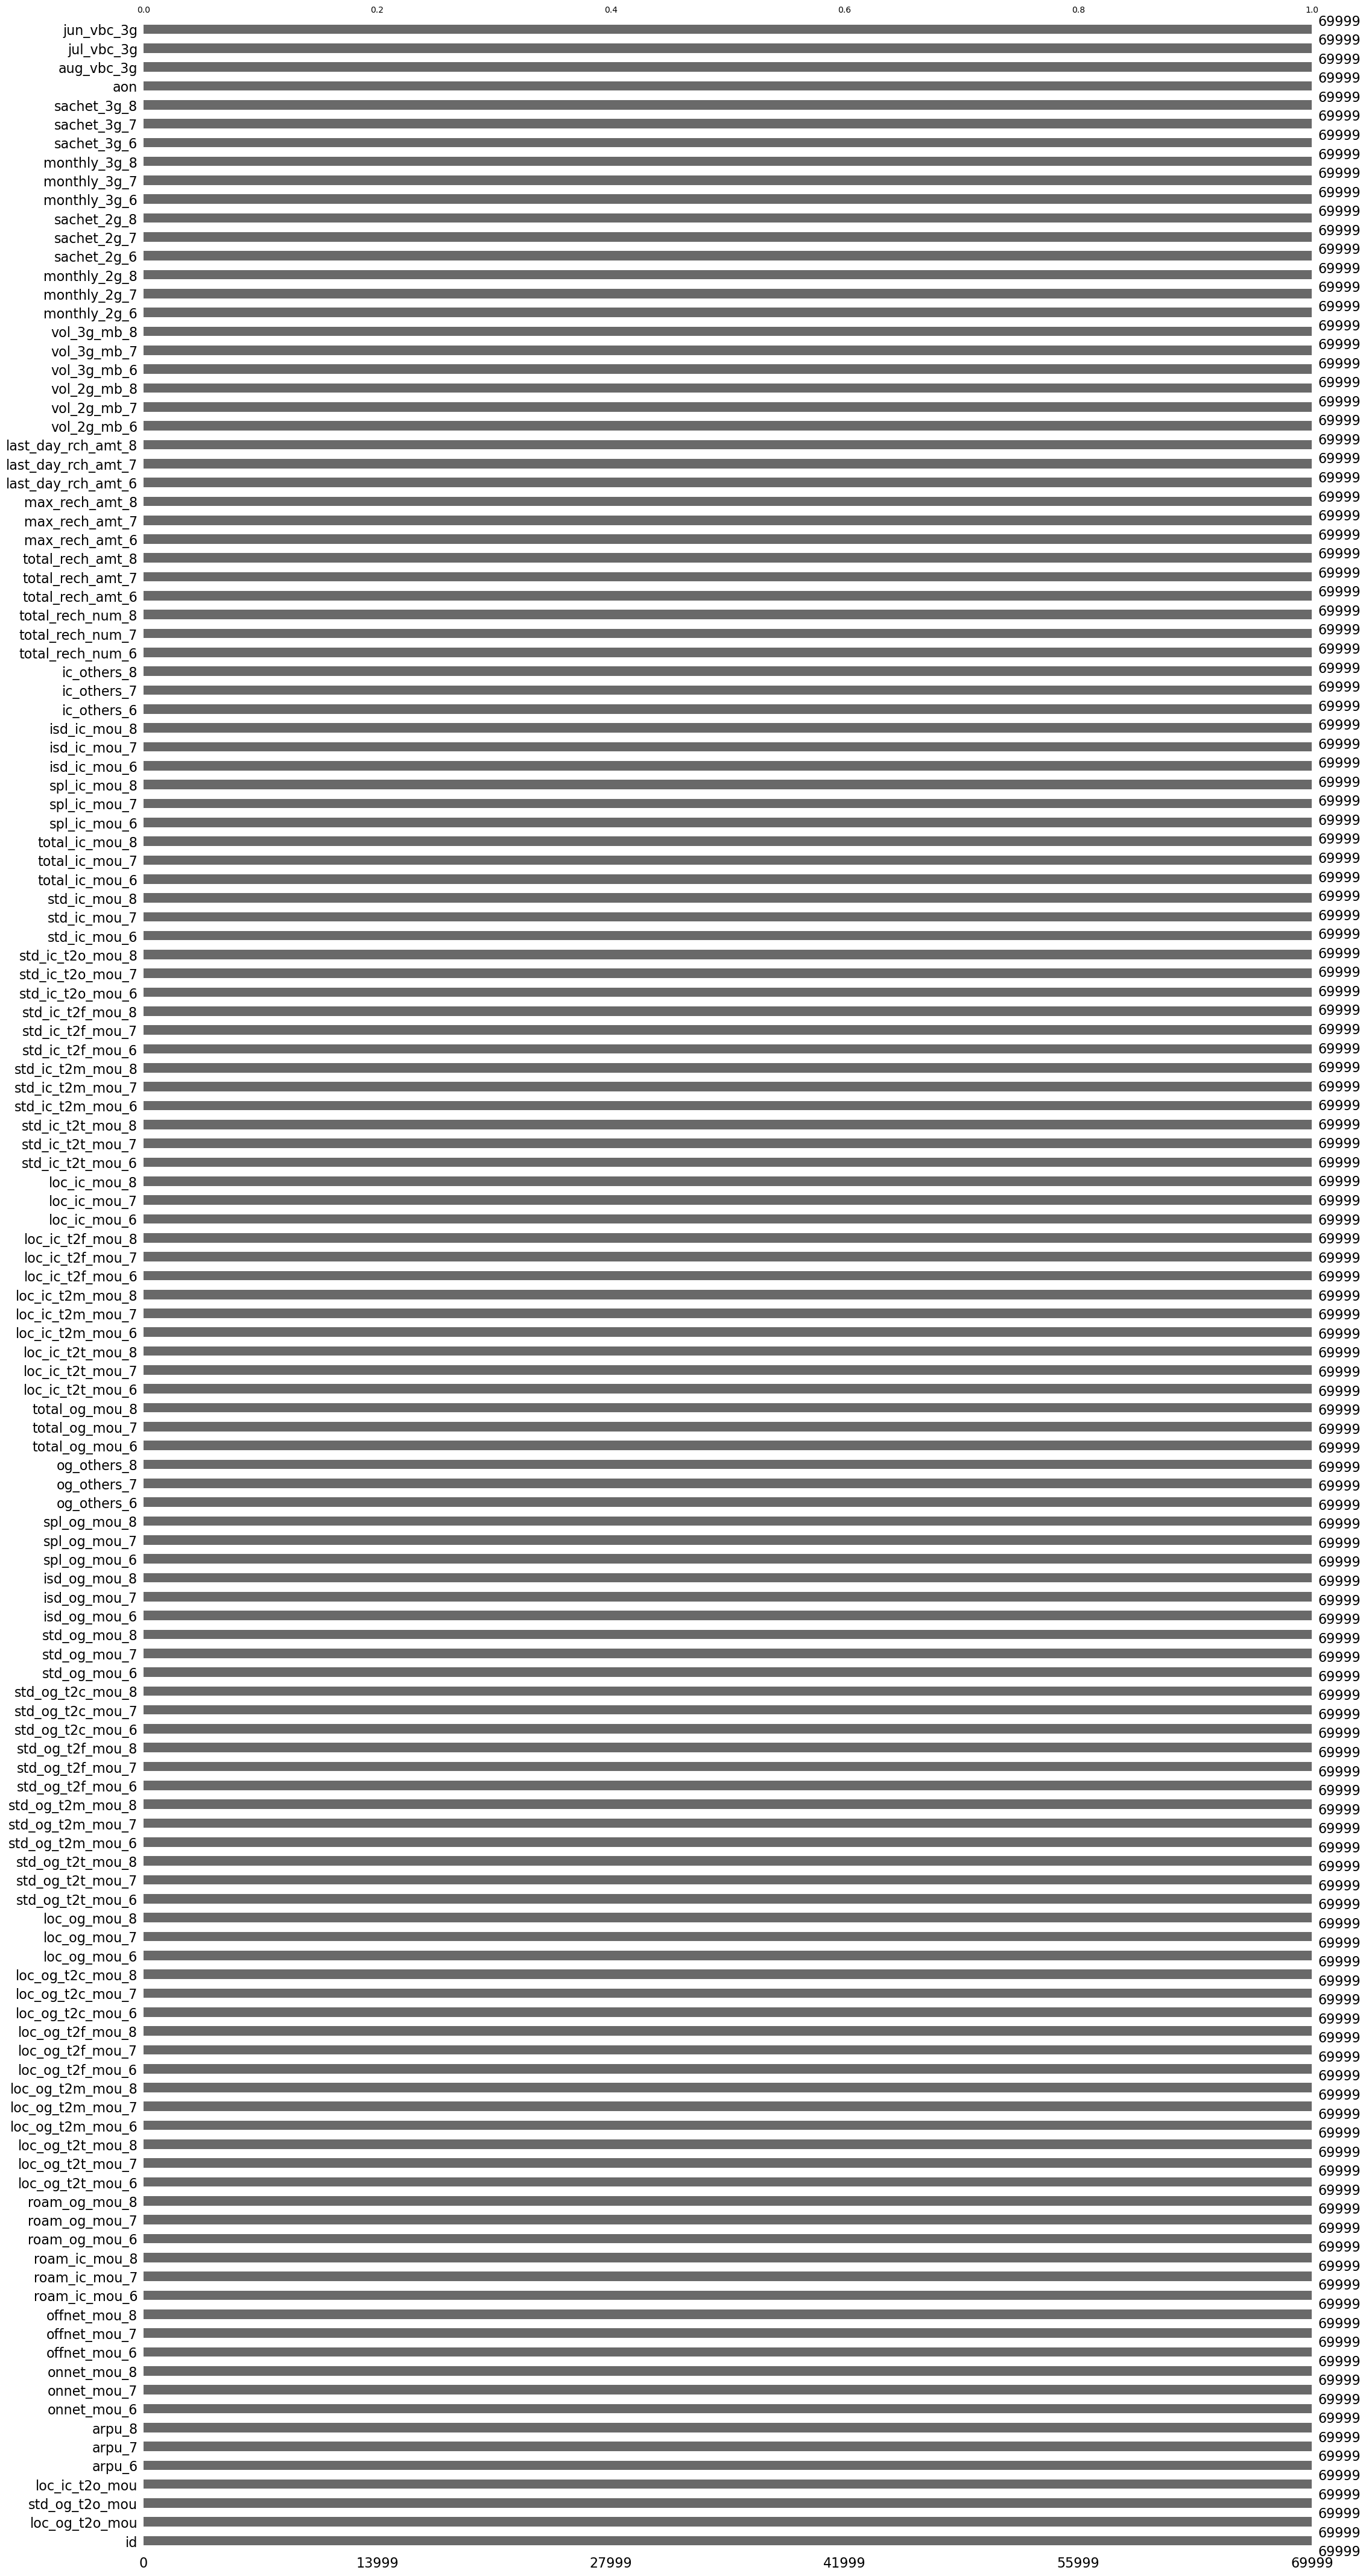

In [325]:
msno.bar(X)

In [326]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 134 entries, id to jun_vbc_3g
dtypes: float64(108), int64(26)
memory usage: 71.6 MB


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [327]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [328]:
X = X.apply(cap_outliers, axis=0)

### 4.2 Test Train Split

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 134), (14000, 134), (55999,), (14000,))

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [330]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

<Axes: xlabel='churn_probability', ylabel='Count'>

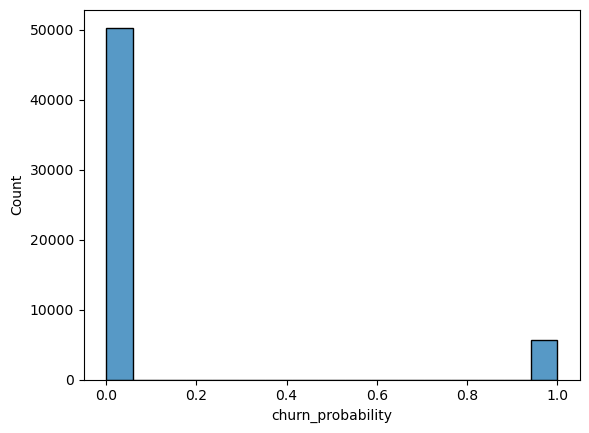

In [331]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [332]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [333]:
new_vars = X.columns
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

In [334]:
feature_importances = feature_importances.sort_values(['importance'], ascending=[False])

In [335]:
feature_importances.head(30)

,col,importance
90,total_ic_mou_8,0.078435
60,total_og_mou_8,0.077360
6,arpu_8,0.042295
105,total_rech_amt_8,0.035277
108,max_rech_amt_8,0.031292
72,loc_ic_mou_8,0.029994
89,total_ic_mou_7,0.021108
66,loc_ic_t2m_mou_8,0.020257
111,last_day_rch_amt_8,0.020187
33,loc_og_mou_8,0.019681


# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [336]:
pca = PCA(0.9)

In [337]:
df_train_pca = pca.fit_transform(X_train)

In [338]:
df_train_pca.shape

(55999, 54)

In [339]:
log_regression = LogisticRegression()

In [340]:
model_pca = log_regression.fit(df_train_pca, y_train)

In [341]:
df_test_pca = pca.transform(X_test)

In [342]:
df_test_pca.shape

(14000, 54)

In [343]:
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]

In [344]:
from sklearn import metrics
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.87'

The model has 87% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [359]:
imp = SimpleImputer(strategy='median', fill_value=0)
scale = StandardScaler()
pca = PCA(0.9)
lr = LogisticRegression(max_iter=1000, tol=0.001)
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [360]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputation', SimpleImputer(fill_value=0, strategy='median')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [361]:
train_score = pipe.score(X_train, y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9065519027125485


In [362]:
test_score = pipe.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.903


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [349]:
confusion_matrix(y_train, pipe.predict(X_train))

array([[49592,   726],
       [ 4507,  1174]])

In [350]:
confusion2 = confusion_matrix(y_test, pipe.predict(X_test))
confusion2

array([[12362,   187],
       [ 1171,   280]])

In [351]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [352]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.19297036526533426

In [353]:
# Let us calculate specificity
TN / float(TN+FP)

0.9850984142162722

In [354]:
precision_score(y_test, pipe.predict(X_test))

0.5995717344753747

In [355]:
recall_score(y_test, pipe.predict(X_test))

0.19297036526533426

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [356]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [357]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [364]:
unseen.set_index('id')

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
id,,,,,,,,,,,,,,,,,,,,,
69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,746.239,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,24.400,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,413.329,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,718.870,396.259,406.150,...,0,0,0,1.0,NaN,NaN,1255,3.71,105.64,61.48
99995,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,218.327,324.070,374.981,...,0,0,0,NaN,0.0,NaN,2258,0.00,0.00,0.00
99996,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,139.473,38.230,180.194,...,0,0,0,NaN,NaN,NaN,440,0.00,0.00,0.00


In [365]:
submission_data = unseen[new_vars]
submission_data.shape

(30000, 134)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [366]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,1
1,70000,0
2,70001,1
3,70002,1
4,70003,1


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [367]:
output.to_csv('submission_razat.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.